In [1]:
import sys
sys.path.append("../")

from photutils.aperture import RectangularAperture, EllipticalAnnulus

import cubespa

from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from matplotlib import interactive

import numpy as np

from tqdm import tqdm

from astropy.io import fits
import warnings
warnings.filterwarnings("ignore")

cubespa.plotting.pyplot_style()

from cubespa.plotting import lavender_cmap

In [2]:
phangs_fn = "../personal/NGC4858_12m+7m_co21_pbcorr_crop.fits"
phangs_mms = "../personal/mm_out_phangs/NGC4858_PHANGS.3.0_1.7"

stellar_ra, stellar_dec = 194.75871125601466, 28.115690196322245

phangs = cubespa.CubeSPA(phangs_fn, mom_maps=phangs_mms, limits="auto", center=(stellar_ra, stellar_dec, "radec"), eps=0.21, position_angle=120)


In [3]:
def quadrants(q1_angle, offset = 90, clockwise=False):
    mult = -1 if clockwise else 1
    return np.array([(q1_angle + i * 90 * mult + offset) for i in range(4)])

def halfline_points(cent, length, angle):

    p1 = (cent[0] , cent[0] + length * np.cos(angle))
    p2 = (cent[1], cent[1] + length * np.sin(angle))
    
    return (p1, p2)


def line_points(cent, length, angle):
    p1 = (cent[0] - length * np.cos(angle), cent[0] + length * np.cos(angle))
    p2 = (cent[1] - length * np.sin(angle), cent[1] + length * np.sin(angle))

    
    return (p1, p2)


def sample_ellipse(x, y, a, e, theta, pa, num_points=100):

    # Calculate semiminor axis
    b = a * (1 - e)

    # Parametric equation for the ellipse
    x_coords = x + a * np.cos(theta) * np.cos(pa) - b * np.sin(theta) * np.sin(pa)
    y_coords = y + a * np.cos(theta) * np.sin(pa) + b * np.sin(theta) * np.cos(pa)

    # Return the sampled coordinates as a NumPy array
    return x_coords, y_coords


def beam_ellipse(x, y, a, b, pa, num_points=100):

    theta = np.linspace(0, np.pi * 2, 50)
    # Calculate semiminor axis

    # Parametric equation for the ellipse
    x_coords = x + a * np.cos(theta) * np.cos(pa) - b * np.sin(theta) * np.sin(pa)
    y_coords = y + a * np.cos(theta) * np.sin(pa) + b * np.sin(theta) * np.cos(pa)

    # Return the sampled coordinates as a NumPy array
    return x_coords, y_coords


In [4]:
thetas = (np.linspace(0, 2 * np.pi, 90)) # These thetas are CCW from +ve y-axis
pa_deg, inc_deg = 30, 38
pa, inc =  np.deg2rad(pa_deg + 90), np.deg2rad(inc_deg)

bar_pa = 65

bmaj, bmin, bpa = phangs.beam

data_co = phangs.mom_maps.mom0.data
stellar_x, stellar_y = phangs.center

pixel_scale = phangs.mom_maps.mom0.header["CDELT2"] * 3600
kpc_per_pix = pixel_scale * 0.468


7.0685834705770345 0.7853981633974483


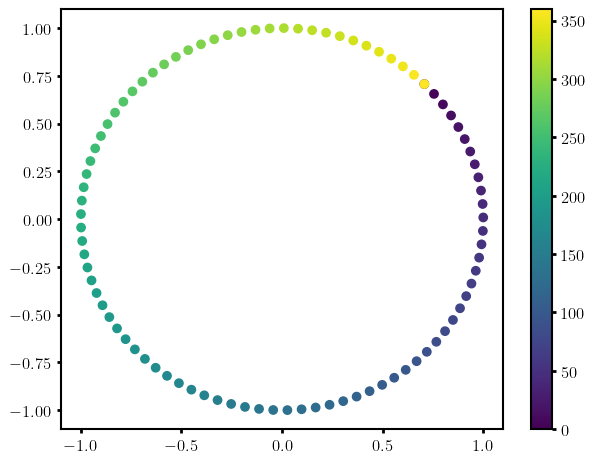

In [5]:
def theta_list(theta_0, clockwise=False, n_samples=90, plot=False, **kwargs):
    outname = kwargs.get("outname", None)

    theta_max = theta_0 + 2*np.pi

    if clockwise:
        _ = theta_0
        theta_0, theta_max = theta_max, _
    
    print(theta_0, theta_max)

    angles = np.linspace(theta_0, theta_max, n_samples) % (2 * np.pi)

    if plot:
        thetas_norm = np.linspace(0, 2*np.pi, n_samples)
        xs, ys = np.cos(angles), np.sin(angles)
        plt.scatter(xs, ys, c=np.rad2deg(thetas_norm))
        plt.colorbar()
        plt.tight_layout()
        if outname is not None:
            plt.savefig(outname, dpi=100)
            plt.close()
        else:
            plt.show()
    
    return angles
        

thetas = theta_list(np.pi/4, clockwise=True, plot=True)


In [6]:
thetas = (np.linspace(0, 2 * np.pi, 90)) # These thetas are CCW from +ve y-axis
# thetas = np.linspace(0, np.pi, 20)

dist, length = 70, 20
width=10


data_nonans = np.copy(phangs.mom_maps.mom0.data)
data_nonans[np.isnan(phangs.mom_maps.mom0.data)] = 0


# plt.xlim(200, 550)
# plt.ylim(400, 900)

fluxes_outer = []
mean_fluxes_outer = []
flux_stds_outer = []

for i, theta in enumerate(thetas):
    theta_adj = theta # + np.pi/2 # This theta is CCW from +ve x-axis
    px, py = phangs.center[0] + dist * np.cos(theta_adj), phangs.center[1] + dist  * np.sin(theta_adj)

    rect = RectangularAperture((px, py), width, length, theta=theta_adj + np.pi / 2)

    mask = rect.to_mask(method='center').to_image(shape=data_co.shape)
    data_slice = np.copy(data_co)
    data_slice[mask == 0] = np.nan

    fluxes_outer.append(np.nansum(data_slice))
    mean_fluxes_outer.append(np.nanmean(data_slice))
    flux_stds_outer.append(np.nanstd(data_slice))



In [7]:
def theta_range(shape, x0, y0, theta, dtheta):
    ys, xs = np.mgrid[:shape[0], :shape[1]].astype(float)
    xs -= x0
    ys -= y0
    
    thetas = (np.arctan2(ys, xs) ) % (2 * np.pi)

    theta_mask = np.ones(thetas.shape)

    theta_min = (theta - dtheta / 2) % (2 * np.pi)
    theta_max = (theta + dtheta / 2) % (2 * np.pi)
    
    # Adjust for cases where theta_max < theta_min due to wrapping around 2pi
    if theta_max < theta_min:
        # In this case, we need to handle the wrap around.
        theta_mask = np.logical_or(thetas >= theta_min, thetas <= theta_max)
    else:
        # Regular case where the range does not wrap around
        theta_mask = np.logical_and(thetas >= theta_min, thetas <= theta_max)

    return theta_mask.astype(int)


theta_range(phangs.mom_maps.mom0.data.shape, phangs.center[0], phangs.center[1], np.pi / 4, 4 * np. pi / 180)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:

def process_azimuth(data, radius, pa, eps, thetas, annulus_width=50, trim_nans=False):

    
    ell_annulus = EllipticalAnnulus((stellar_x, stellar_y), radius, radius + annulus_width, 
                                    (radius + annulus_width) * (1-eps), theta = pa)
    mask = ell_annulus.to_mask(method='center').to_image(shape=data_co.shape)
    
    data_init_mask = np.copy(data)
    data_init_mask[mask == 0] = np.nan

    fluxes, flux_stds = [], []

    for i, theta in tqdm(enumerate(thetas[:])):
    
        theta_mask = theta_range(data_co.shape, stellar_x, stellar_y, theta, 5 * np.pi / 180)
    
        this_data = np.copy(data_init_mask)
        this_data[theta_mask == 0] = np.nan
        try:
            med, std = np.nanmedian(this_data), np.nanstd(this_data)
        except RuntimeWarning:
            med, std = np.nan, np.nan
            
        fluxes.append(med)
        flux_stds.append(std)

    if trim_nans:
        fluxes = np.array(fluxes)
        fluxes[np.isnan(fluxes)] = 0

        flux_stds = np.array(flux_stds)
        flux_stds[np.isnan(flux_stds)] = 0
    
    return (np.array(fluxes), np.array(flux_stds), ell_annulus)


In [9]:
def segment_sum(cubespa_obj, data, radius, annulus_width, theta_0, plot=False, clockwise=False, method="sum"):
    stellar_x, stellay_y = cubespa_obj.center
    
    eps, pa = cubespa_obj.eps, cubespa_obj.position_angle

    # print(stellar_x, stellar_y, eps, pa)
    ell_annulus = EllipticalAnnulus((stellar_x, stellar_y), 
                                    radius, radius + annulus_width, 
                                    (radius + annulus_width) * (1-eps), 
                                    theta = pa)
    mask = ell_annulus.to_mask(method='center').to_image(shape=data.shape)
    
    data_init_mask = np.copy(data)
    data_init_mask[mask == 0] = np.nan

    theta_mask = theta_range(data_co.shape, stellar_x, stellar_y, np.deg2rad(theta_0) + np.pi/4, np.pi / 2)

    data_init_mask[theta_mask == 0] = np.nan
    pixel_sum = np.nansum(data_init_mask)

    if plot:
        plt.imshow(data, origin="lower", cmap="Greys")
        plt.imshow(data_init_mask, cmap="viridis", origin="lower", alpha=0.7)
        plt.imshow(theta_mask, alpha=0.2, cmap="Greys", origin="lower")
        ell_annulus.plot(color="black")
        plt.title(f'{radius:.1f} {theta_0}\n{pixel_sum:.2f}', fontsize=10)
        plt.show()

    return pixel_sum


0 6.283185307179586


90it [00:00, 263.16it/s]
90it [00:00, 283.59it/s]
90it [00:00, 279.48it/s]
90it [00:00, 299.07it/s]
90it [00:00, 288.07it/s]
90it [00:00, 293.75it/s]
90it [00:00, 304.48it/s]


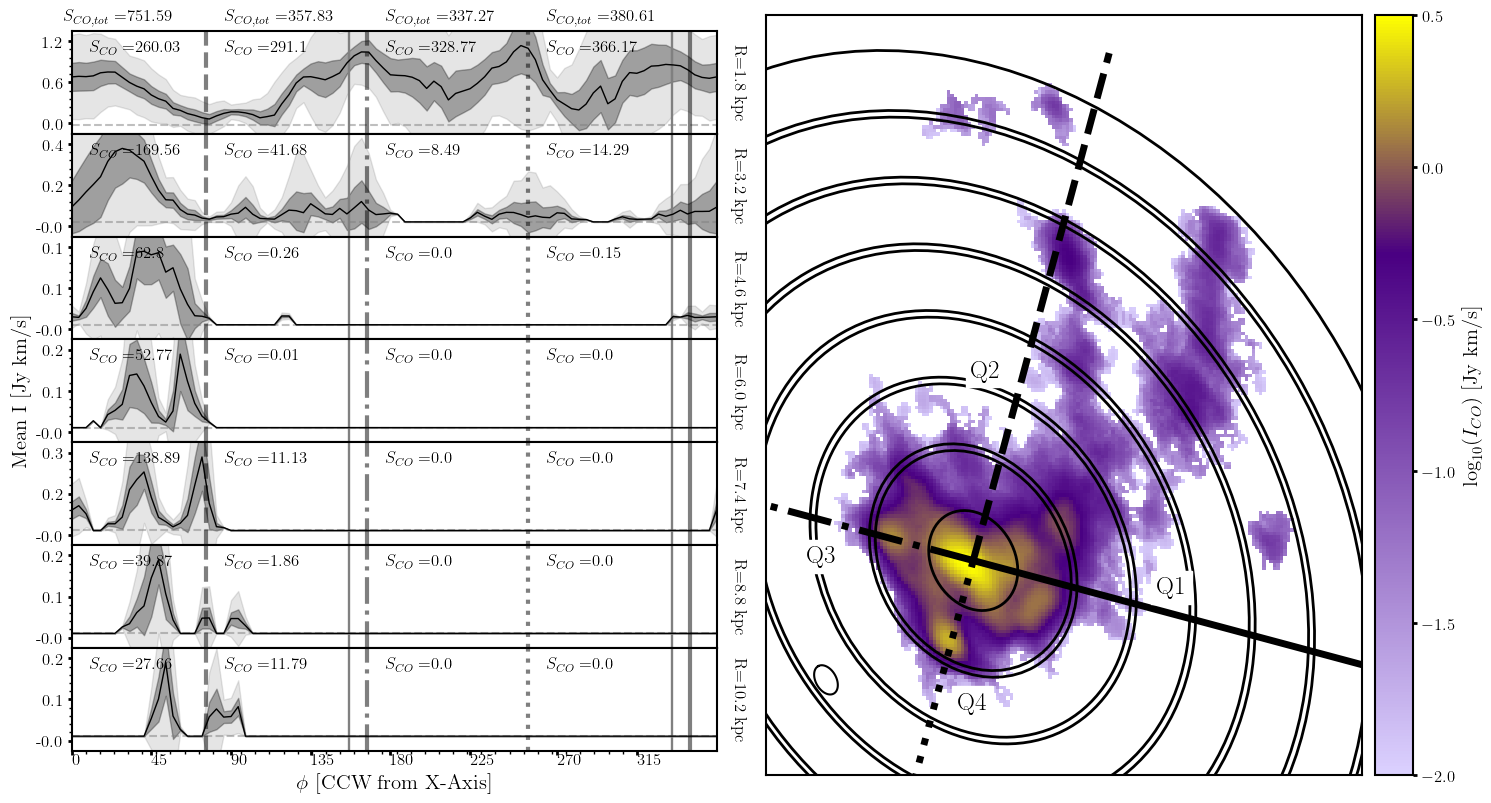

In [21]:

def azimuthal_plot(data, cubespa_obj, radii, annulus_width=18, theta_0 = 0, clockwise=True, outname=None, theta_samples=90, q0=75,  **kwargs):
    # TODO generate these automatically from theta_0 and clockwise
    thetas_uniform = np.linspace(0, 360, theta_samples)
    thetas = theta_list(theta_0, clockwise=clockwise, n_samples=theta_samples)
    thetas_adj = np.rad2deg(thetas)

    eps = cubespa_obj.eps if cubespa_obj.eps is not None else 0.
    pa = cubespa_obj.position_angle if cubespa_obj.position_angle is not None else 0

    figsize = kwargs.get("figsize", (16, 8))
    plot_sums = kwargs.get("plot_sums", True)
    xlabel, ylabel = kwargs.get("xlabel", r'$\phi$ [CCW from X-Axis]'), kwargs.get("ylabel", r'Mean I [Jy km/s]')

    vmin, vmax = kwargs.get("vlims", [-50, 50])

    cmap = kwargs.get("cmap", "viridis")
    log_img = kwargs.get("log_img", False)

    colorbar_label = kwargs.get("colorbar_label", ylabel) # Just use the ylabel from the azimuthal plots if not otherwise specified

    dr = np.mean(np.diff(radii))

    if cubespa_obj.limits is None:
        lims = cubespa.check_kwarg("limits", [0, data.shape[0], 0, data.shape[1]], kwargs) 
    else:
        lims = cubespa.pad_limits(cubespa_obj.limits, padding=10)
    xmin, xmax, ymin, ymax = lims
    dx, dy = xmax - xmin, ymax - ymin

    styles = ['solid', 'dashed', 'dashdot', 'dotted']

    qs = quadrants(q0, offset=0, clockwise=clockwise) % 360
    
    # Get all flux sets and quadrant sums
    sets, quadrant_fluxsums = [], []
    for r in radii:
        sets.append(process_azimuth(data, r, pa, eps, thetas, annulus_width=annulus_width, trim_nans=True))
        row_sums = []
        for q in qs:
            row_sums.append(segment_sum(cubespa_obj, data, radius=r, annulus_width=annulus_width, theta_0=q, plot=False))
        quadrant_fluxsums.append(row_sums)

    fig = plt.figure(figsize=figsize, facecolor="white")
    
    xwidth = 0.43
    yheight, yspacing, ymin_pad = 0.90 / len(sets), 0, 0.060

    axes = []
    for i in range(len(sets) -1, -1, -1):
        axes.append(fig.add_axes([0.05, ymin_pad + i * (yheight + yspacing), xwidth, yheight]))
    img_ax = fig.add_axes([0.51, 0.03, 0.435, 0.95])
    
    # Plot all azimuthal profiles and all the quadrant stuff
    for i, set in enumerate(sets):
        flux_lims = kwargs.get("flux_lims", None)
        if flux_lims is not None:
            axes[i].set_ylim(flux_lims)
        else:
            flux_min, flux_max = np.min(set[0]), np.max(set[0])
            df = flux_max - flux_min
            if df > 1e-5:
                axes[i].set_ylim(flux_min - df/5, flux_max + df/5)
        
        if kwargs.get("nan_0s", False):
            set[0][np.isclose(set[0], 0)] = np.nan

        color = kwargs.get("colors", "black")

        axes[i].plot(thetas_uniform, set[0], color=color, zorder=3, lw=1)
        axes[i].fill_between(thetas_uniform, set[0] - set[1], set[0] + set[1], color=color, zorder=2, alpha=0.3)
        axes[i].fill_between(thetas_uniform, set[0] - 3 * set[1], set[0] + 3 * set[1], color=color, zorder=2, alpha=0.1)
        
        axes[i].axhline(0, ls="dashed", color="Grey", zorder=2, alpha=0.5)
        
        axes[i].set_xlim(0, 360)
        ax_xmin, ax_xmax = axes[i].get_xlim()
        ax_ymin, ax_ymax = axes[i].get_ylim()
        xspan, yspan = ax_xmax - ax_xmin, ax_ymax - ax_ymin

        axes[i].text(ax_xmax + xspan / 30, ax_ymax - yspan / 2, 
                     f'R={(radii[i] + dr / 2) * kpc_per_pix:.1f} kpc',  # Inner radius plus dr / 2 for the annulus center
                     ha = "center", va = "center",
                     rotation=-90)
        
        yticks = np.linspace(ax_ymin + yspan / 10, ax_ymax - yspan / 10, 3)
        ytick_labels = [f"{y:.1f}" for y in yticks]

        axes[i].set_yticks(np.linspace(min(yticks), max(yticks), 11), minor=True)
        axes[i].set(yticks=yticks, yticklabels=ytick_labels)

        if kwargs.get("grid", False):
            axes[i].grid(which="both", alpha=0.2)

        # Plot fiducial velocities
        if kwargs.get("plot_fiducial", False) and i != 0:
            axes[i].plot(thetas_adj, sets[0][0], color="Grey", zorder=2, alpha=0.5)
    
        if i is not len(sets):
            axes[i].tick_params(labelbottom=False)    

        for j, q in enumerate(qs):
            axes[i].axvline(q, color="black", linestyle=styles[j], lw=3, alpha=0.5)
            
            # Plot quadrant number
            text_x = np.max([q - 80, 10])
            
            qsum = np.round(quadrant_fluxsums[i][(j - 1) % 4], 2)
            if plot_sums:
                axes[i].text(text_x, ax_ymax - yspan / 5, r'$S_{CO} =$' + str(qsum))            

            axes[i].axvline(bar_pa + 90, color="Grey")
            axes[i].axvline(bar_pa + 90 + 180, color="Grey")


        axes[i].set_xticks([])

    
    axes[int(len(axes) / 2)].set_ylabel(ylabel, fontsize=15)
    
    ticks = np.array([0, 11, 22, 33, 44, 55, 67, 78])

    ticks = thetas_uniform[ticks]
    ticklabels = ["0", "45", "90", "135", "180", "225", "270", "315"]
    
    for i in axes:
        i.set_xticks(ticks=ticks)
        i.set_xlabel([], fontsize=15,  labelpad=10)
        i.set_xticks(np.linspace(min(ticks), max(ticks), len(ticks) * 5 + 1), minor=True) 

    
    for i, t in enumerate(ticks):
        axes[-1].text(t, ax_ymin - yspan / 8, ticklabels[i])

    axes[len(axes) - 1].set_xticks(ticks=ticks)
    axes[len(axes) - 1].set_xlabel(xlabel, fontsize=15,  labelpad=10)
    axes[len(axes) - 1].set_xticks(np.linspace(min(ticks), max(ticks), len(ticks) * 5 + 1), minor=True)


    # Add and clean up the image plot
    if log_img:
        img_map = img_ax.imshow(np.log10(data), origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    else:
        img_map = img_ax.imshow(data, origin="lower", cmap=cmap, vmin=vmin, vmax=vmax)
    
    img_ax.set_xlim(xmin, xmax)
    img_ax.set_ylim(ymin, ymax)

    for i, q in enumerate(qs):
        ylims = axes[0].get_ylim()
        
        qsum = np.sum(np.transpose(quadrant_fluxsums)[(i - 1) % 4])
        qsum = np.round(qsum, 2)
        
        if plot_sums:
            axes[0].text(q - 80, ylims[1] * 1.1, r'$S_{CO, tot}=$' + str(qsum))
    
        q = np.deg2rad(q)
        points = halfline_points((stellar_x, stellar_y), 150, q)
        
        img_ax.plot(points[0], points[1], color="black", lw=5, linestyle=styles[i])

        mean_x, mean_y = np.mean(points[0]), np.mean(points[1])
        
        shifts_x = [-20, -20, 25, 15]
        shifts_y = [10, -20, -20, 30]
        img_ax.text(mean_x + shifts_x[i], mean_y + shifts_y[i], f"Q{(i) % 4 + 1}",  fontsize=18, backgroundcolor="white", zorder=4)
        
    img_ax.set_xticks([])
    img_ax.set_yticks([])

    for i, s in enumerate(sets):
        s[2].plot(color=color, lw=2, ax=img_ax, zorder=3)

    cb = plt.colorbar(mappable=img_map, ax=img_ax, fraction=0.06, pad=0.02)
    cb.set_label(label=colorbar_label, fontsize=15)
    
    # # Draw beam
    # if cubespa_obj.beam is not None:
    #     bmaj, bmin, bpa  = cubespa_obj.get_beam_pix()
    #     beam_x, beam_y = beam_ellipse(xmin + dx/10, ymin + dy/8, bmaj /2, bmin /2, np.deg2rad(bpa))
    #     img_ax.plot(beam_x, beam_y, color="black", zorder=2)
    img_ax.plot(*cubespa_obj.get_beam_coords(xmin + dx/10, ymin + dy/8), color="black")

    
    if outname is not None:
        plt.savefig(outname, dpi=200)
        plt.savefig(f"{outname.removesuffix('.pdf')}.png", dpi=200)
        #plt.close()
    else:
        plt.show()

data_co = phangs.mom_maps.mom0.data
azimuthal_plot(data_co, phangs, np.arange(10, 150, 20) + 5, 
               log_img=True, vlims=[-2, 0.5], 
               cmap=lavender_cmap(), figsize=(15, 8),
               colorbar_label=r'$\log_{10}(I_{CO})$ [Jy km/s]', 
               clockwise=False, q0=-15, plot_sums=True, 
               grid=False,
               outname="../personal/PubPlots/Azimuthal_Flux.pdf")



165


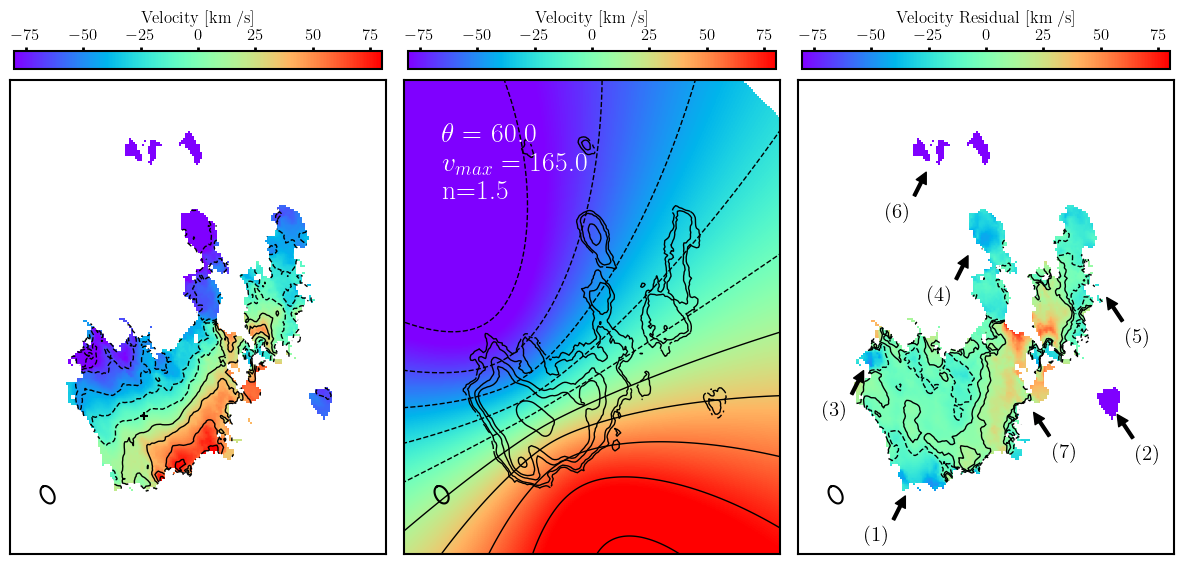

In [22]:


vmin, vmax = -50, 165
pa_deg, inc_deg = 60, 38
pa, inc =  np.deg2rad(pa_deg), np.deg2rad(inc_deg)

vsys = 9150

Rmax, R_d = 90, 60

n=1.5

data_vel = phangs.mom_maps.mom1.data - vsys
mod = cubespa.VelocityModel(data_vel.shape, x0=stellar_y, y0=stellar_x, rmax=Rmax, inc=inc_deg, pa=pa_deg, vsys=0)
vmod = mod.gen_model(cubespa.brandt_curve, rmax=mod.rmax, n=n, vmax=vmax)

mod.write_model("../personal/VelocityModel.dat")

fig, ax = plt.subplots(1, 3, figsize=(12, 6), facecolor="white")

xmin, xmax, ymin, ymax = cubespa.pad_limits(phangs.limits, 15)
dx, dy = xmax - xmin, ymax - ymin

ys, xs = np.mgrid[:data_vel.shape[0], :data_vel.shape[1]]

co_levels = [2, 4,  12, 20, 50, 200]
mom0_rms = phangs.cube_rms * np.sqrt(len(phangs.velocities))


im1 = ax[0].imshow(data_vel, cmap="rainbow", origin="lower", vmin=-80, vmax=80)
im2 = ax[1].imshow(vmod, cmap="rainbow", origin="lower", vmin=-80, vmax=80)

im3 = ax[2].imshow(data_vel - vmod, cmap="rainbow", origin="lower", vmin=-80, vmax=80)

#ax[0].contour(xs, ys, vmod, colors="black", levels=np.linspace(-vmax, vmax, 20), linewidths=1)
print(vmax)
dv = 20
ax[0].contour(xs, ys, data_vel, colors="black", levels=np.arange(-vmax, vmax + dv, dv), linewidths=1)
ax[1].contour(xs, ys, vmod, colors="black", levels=np.arange(-vmax, vmax + dv, dv), linewidths=1)
ax[1].contour(xs, ys, data_co, colors="black", levels=[mom0_rms * i for i in co_levels], linewidths=1)

ax[2].contour(xs, ys, data_vel - vmod, colors="black", levels=[-10, 0, 10], linewidths=1)

ax[0].scatter(stellar_x, stellar_y, color="black", marker="+")


ax[1].text(xmin + dx / 10, ymax - dy/4, r'$\theta$ = ' + f'{pa_deg:.1f}\n' + r'$v_{max} =$ ' + f'{vmax:.1f}\n n={n}', color="white", fontsize=20)


fontsize=15
arrowprops = dict(facecolor='black', shrink=0.08, width=2, headwidth=8, headlength=8)

ax[2].annotate(f'(1)', xy=(110, 70), xytext=(90, 50), fontsize=fontsize, ha='left', va='center', color="black",
            arrowprops=arrowprops)
ax[2].annotate(f'(2)', xy=(210, 109), xytext=(220, 89), fontsize=fontsize, ha='left', va='center', color="black",
            arrowprops=arrowprops)
ax[2].annotate(f'(7)', xy=(170, 110), xytext=(180, 90), fontsize=fontsize, ha='left', va='center', color="black",
            arrowprops=arrowprops)
ax[2].annotate(f'(3)', xy=(90, 130), xytext=(70, 110), fontsize=fontsize, ha='left', va='center', color="black",
            arrowprops=arrowprops)

ax[2].annotate(f'(4)', xy=(140, 185), xytext=(120, 165), fontsize=fontsize, ha='left', va='center', color="black",
            arrowprops=arrowprops)
ax[2].annotate(f'(5)', xy=(205, 165), xytext=(215, 145), fontsize=fontsize, ha='left', va='center', color="black",
            arrowprops=arrowprops)
ax[2].annotate(f'(6)', xy=(120, 225), xytext=(100, 205), fontsize=fontsize, ha='left', va='center', color="black",
            arrowprops=arrowprops)

for axis in ax.flatten()[:]:
    axis.set_xlim(xmin, xmax)
    axis.set_ylim(ymin, ymax)
    axis.set_xticks([])
    axis.set_yticks([])

    axis.plot(*phangs.get_beam_coords(xmin + dx/10, ymin + dy/8), color="black")




plt.colorbar(mappable=im1, ax=ax[0], location="top", label = "Velocity [km /s]", fraction=0.035, pad=0.02)
plt.colorbar(mappable=im2, ax=ax[1], location="top", label = "Velocity [km /s]", fraction=0.035, pad=0.02)
plt.colorbar(mappable=im3, ax=ax[2], location="top", label = "Velocity Residual [km /s]", fraction=0.035, pad=0.02)
plt.tight_layout()
plt.savefig('../personal/velocity_residual.pdf', dpi=150)

0 6.283185307179586


90it [00:00, 302.75it/s]
90it [00:00, 301.01it/s]
90it [00:00, 310.00it/s]
90it [00:00, 315.20it/s]
90it [00:00, 310.14it/s]
90it [00:00, 312.62it/s]
90it [00:00, 303.55it/s]


0 6.283185307179586


90it [00:00, 305.25it/s]
90it [00:00, 320.21it/s]
90it [00:00, 328.15it/s]
90it [00:00, 332.47it/s]
90it [00:00, 332.80it/s]
90it [00:00, 336.05it/s]
90it [00:00, 300.41it/s]


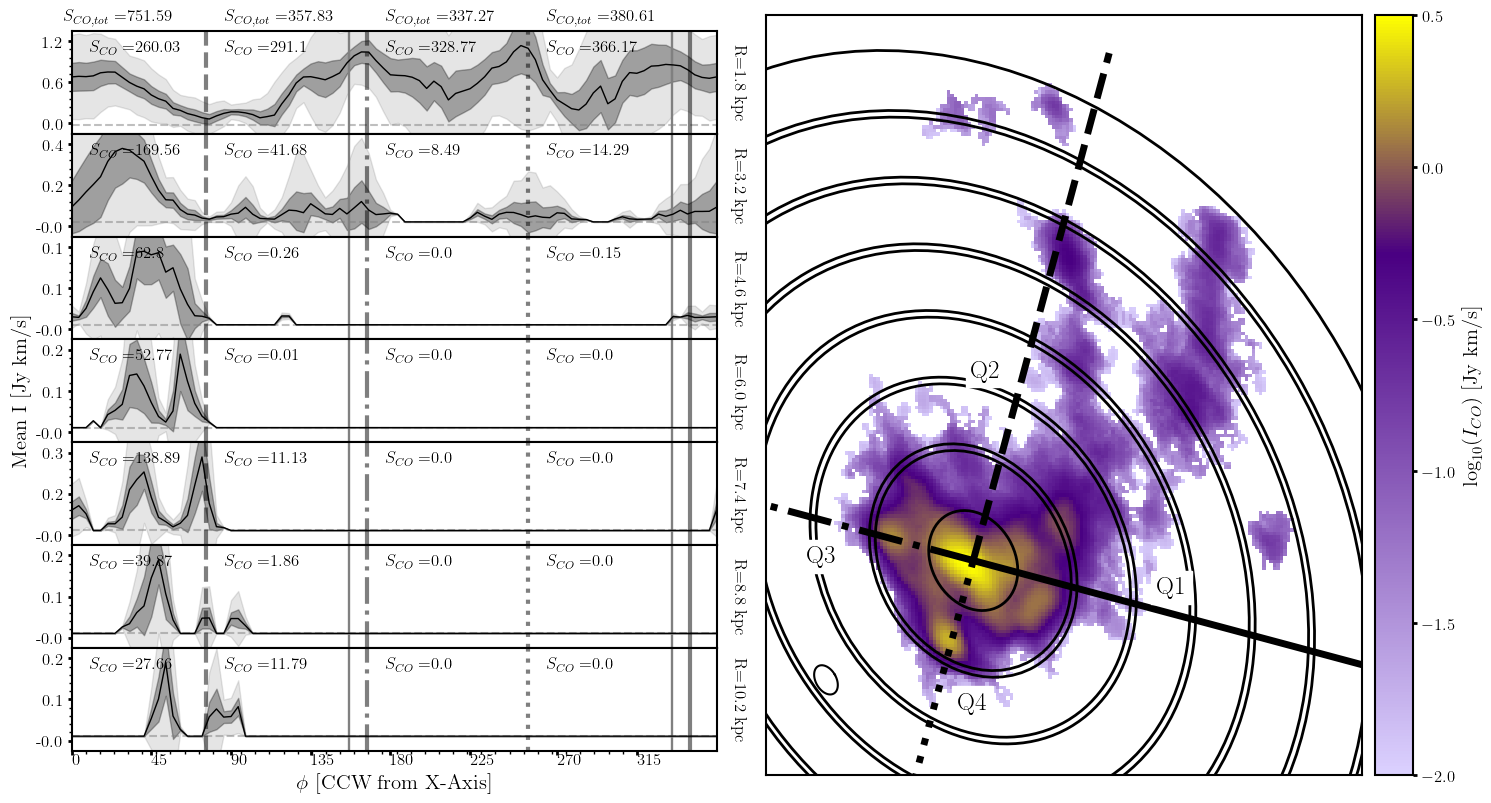

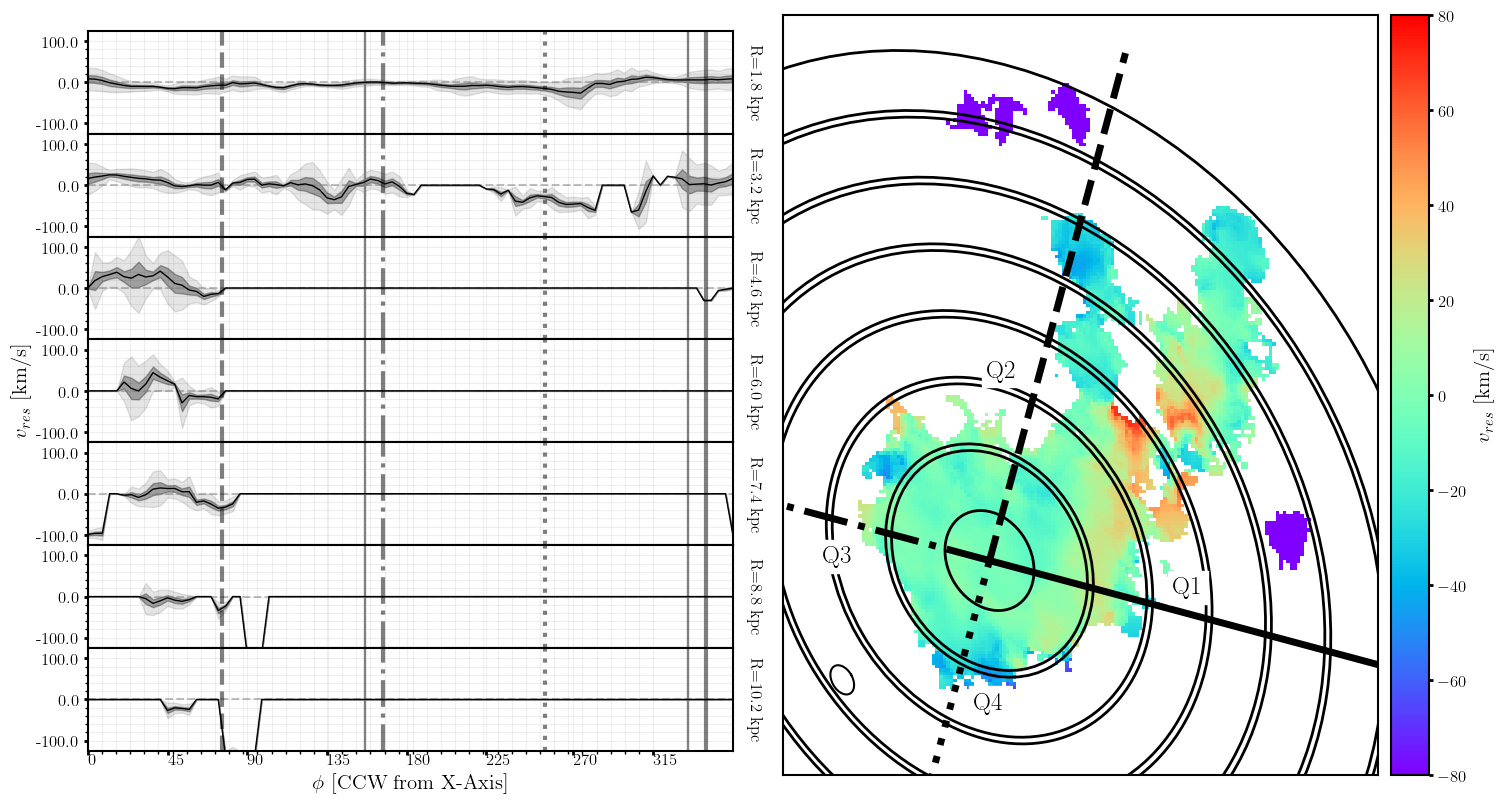

In [20]:
azimuthal_plot(data_co, phangs, np.arange(10, 150, 20) + 5, 
               log_img=True, vlims=[-2, 0.5], 
               cmap=lavender_cmap(), figsize=(15, 8),
               colorbar_label=r'$\log_{10}(I_{CO})$ [Jy km/s]', 
               clockwise=False, q0=-15, plot_sums=True, 
               outname="../personal/PubPlots/Azimuthal_Flux.pdf")

# 62.5 corresponds to 50 on the yticks
azimuthal_plot(data_vel - vmod, phangs, np.arange(10, 150, 20) + 5, 
               log_img=False, vlims=[-80, 80], 
               cmap="rainbow", figsize=(15, 8),
               flux_lims=[-125, 125],
               nan_0s=False,
               ylabel= r'$v_{res}$ [km/s]',
               grid=True,
               colorbar_label=r'$v_{res}$ [km/s]', 
               clockwise=False, q0=-15, plot_sums=False, 
               outname="../personal/PubPlots/Azimuthal_VelocityResid.pdf")
